In [1]:
# First import a bunch of useful stuff

import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from plotter import *

In [2]:
# This gives the integrated luminosity (the amount of data collected) for each year
lumis = {}
lumis['2017'] = 41.5

In [3]:
# This dictionary gives the cross section (expected rate) of each simulated process
# Number of events of process P = integrated luminosity * cross section of process P
with open('xsec.json') as f:
  xs = json.load(f)
print(xs)

{'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 32200, 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 6839, 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 1207, 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 120.1, 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 25.24, 'QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8': 20.23, 'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madg

In [4]:
# This dictionary tells us how to group the simulated samples together sensibly
# For example, QCD is generated separately for different energies. Combine them
with open('pmap.json') as f:
  pmap = json.load(f)
print(pmap)

{'ZH': ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8,'], 'WH': ['WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8'], 'ttH': ['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'], 'VBF': ['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'], 'ggF': ['GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8'], 'ggF-powheg': ['GluGluHToBB_M125_TuneCP5_13TeV-powheg-pythia8', 'GluGluHToBB_M125_13TeV_powheg_pythia8'], 'QCD': ['QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1500to2000_TuneC

In [5]:
year = '2017'
outsum = processor.dict_accumulator()

In [6]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [7]:
vh1_repickle = not os.path.isfile('vh1_pickle.pkl')
picklename = 'vh1_pickle.pkl'
if vh1_repickle:
    nfiles = len(subprocess.getoutput("ls infiles-bsm-vbf/"+year+"*.json").split())
    
    for n in range(1,76):

        with open('infiles-bsm-vh/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        filename = 'outfiles-ddb2/%s_%d.coffea'%(year, n)
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys(), filename)
            #print("File " + filename + " is missing")
            
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vh-1'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [8]:
vh2_repickle = not os.path.isfile('vh2_pickle.pkl')
picklename = 'vh2_pickle.pkl'
if vh1_repickle:
    nfiles = len(subprocess.getoutput("ls infiles-bsm-vbf/"+year+"*.json").split())
    
    for n in range(1,76):

        with open('infiles-bsm-vh/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        filename = 'outfiles-ddb2/%s_%d.coffea'%(year, n)
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys(), filename)
            #print("File " + filename + " is missing")
            
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vh-2'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [9]:
vbf_repickle = not os.path.isfile('vbf_pickle.pkl')
picklename = 'vbf_pickle.pkl'
if vbf_repickle:
    nfiles = len(subprocess.getoutput("ls infiles-bsm-vbf/"+year+"*.json").split())
    
    for n in range(1,nfiles+1):

        with open('infiles-bsm-vbf/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        filename = 'outfiles/%s_%d.coffea'%(year, n)
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys(), filename)
            #print("File " + filename + " is missing")
            
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vbf'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [10]:
vbfpickle = 'vbf_pickle.pkl'
vh1pickle = 'vh1_pickle.pkl'
vh2pickle = 'vh2_pickle.pkl'


# Read the histogram from the pickle file
templates = pickle.load(open(vbfpickle,'rb'))

# Sum over all bins and print the total number of events per process
templates.sum('msd1','ddb1', 'pt1', 'deta', 'mjj').values()

# Read the histogram from the pickle file
templatesvh1 = pickle.load(open(vh1pickle,'rb'))

# Sum over all bins and print the total number of events per process
templatesvh1.sum('msd1','ddb1', 'msd2', 'ddb2', 'ddc2').values()

{('WH_0L1f05ph0',): 425236.3386334816,
 ('WH_0L1',): 428017.0427475972,
 ('WH_0Mf05ph0',): 36390.91367152966,
 ('WH_0M',): 61719.61737457803,
 ('WH_0PHf0tph0',): 79046.50820832732,
 ('WH_0PH',): 42897.15225086178,
 ('WH_0PM',): 3826.93246749599,
 ('ZH_0Lf05ph0',): 383904.8178442374,
 ('ZH_0L1',): 359841.7498830253,
 ('ZH_0Mf05ph0',): 29552.807562969985,
 ('ZH_0M',): 58018.644113048504,
 ('ZH_0PHf05ph0',): 66745.5255684998,
 ('ZH_0PH',): 36246.746210295925,
 ('ZH_0PM',): 3504.3041797611054}

In [11]:
def plot_bsm(temp, v, save_title, mode, norm=False):
    '''
    plot histogram of bsm samples 
    temp: histogram, samples
    v: string, variable to plot by, must be a variable in temp
    save_title: string, location to save plot
    mode: string 'zh', 'wh', 'vh', 'vbf',
    norm: boolean, whether or not to normalize the samples by area
    
    '''
    
    if mode == 'vbf':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, mjj, deta, or pt1')

        res = temp.integrate('systematic', 'nominal')#.integrate('process')
    if mode[-1] == 'h':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'msd2':[68, 103], 'ddb2':[0, 1], 'ddc2':[0, 1]}
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, msd2, ddb2, ddc2')

        res = temp
        
        
    for x in vals.keys():
        if not v==x:
            res = res.integrate(x, int_range=slice(*vals[x]))
    plt.figure()
    hist.plot1d(res, density=norm)#, legend_opts={'labels':['standard model']})
    
    plt.title("bsm %s by %s"%(mode, v))
    plt.tight_layout()
    plt.savefig(save_title)

In [12]:
#separate wh and zh

wlabels = [x for x in templatesvh1.identifiers('process') if str(x)[0]=='W']
zlabels = [x for x in templatesvh1.identifiers('process') if str(x)[0]=='Z']
templatesw = templatesvh1.remove(zlabels, 'process')
templatesz = templatesvh1.remove(wlabels, 'process')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d1f46dac0>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(


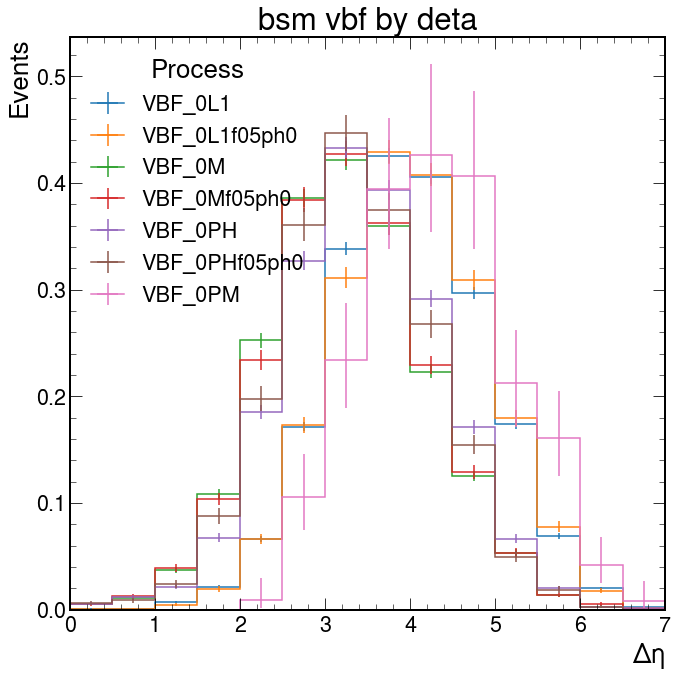

In [13]:
plot_bsm(templates, 'deta', 'deta_bsm_normv2.png', 'vbf', norm=True)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8

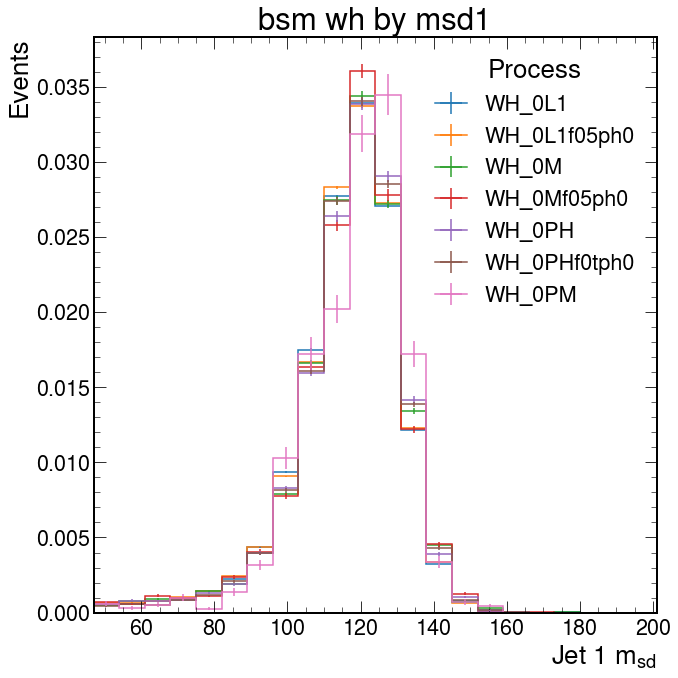

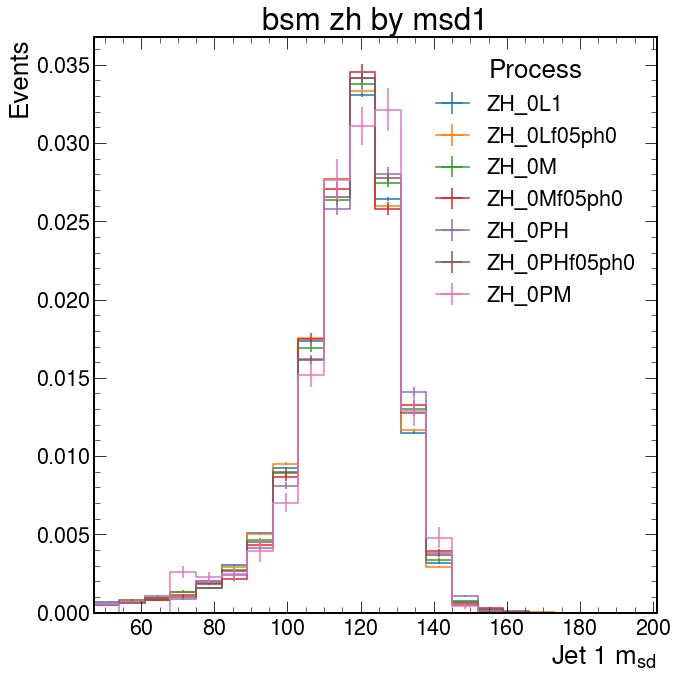

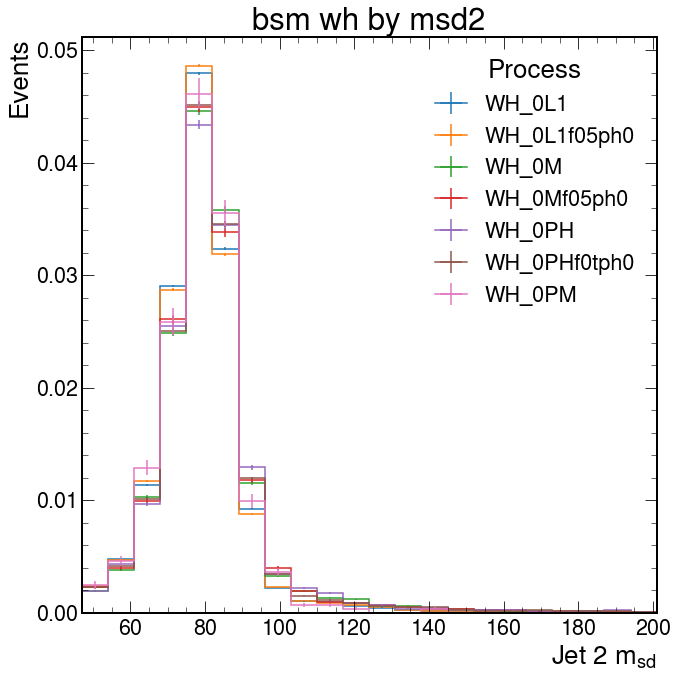

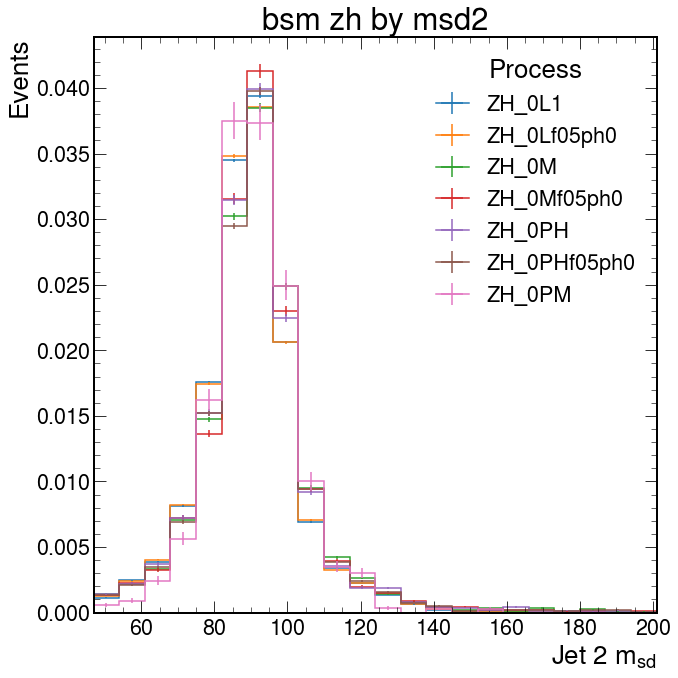

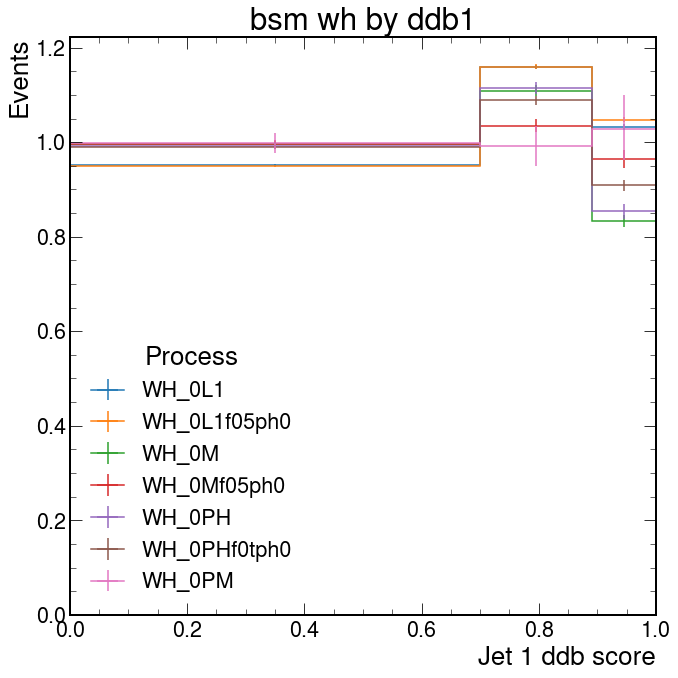

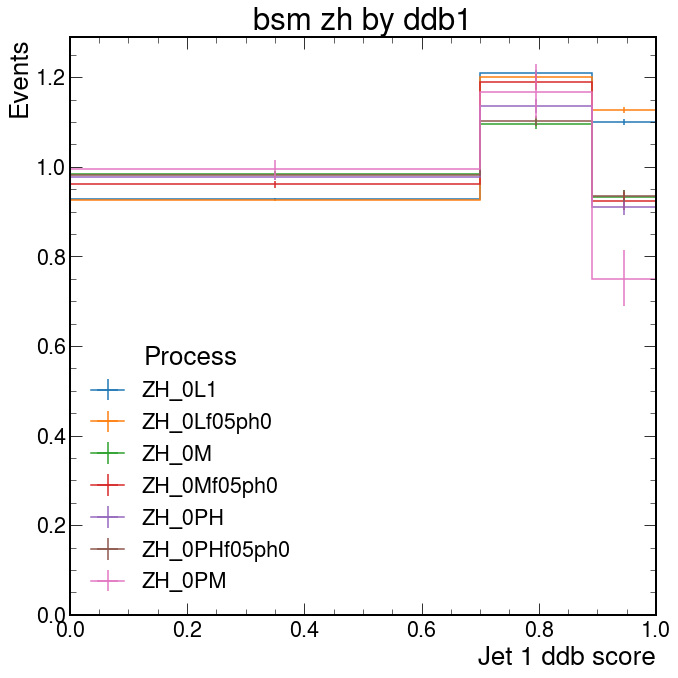

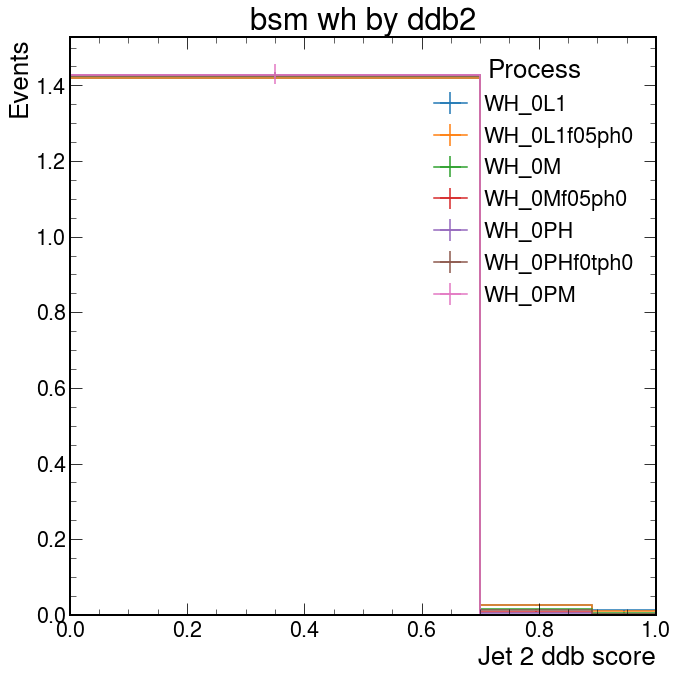

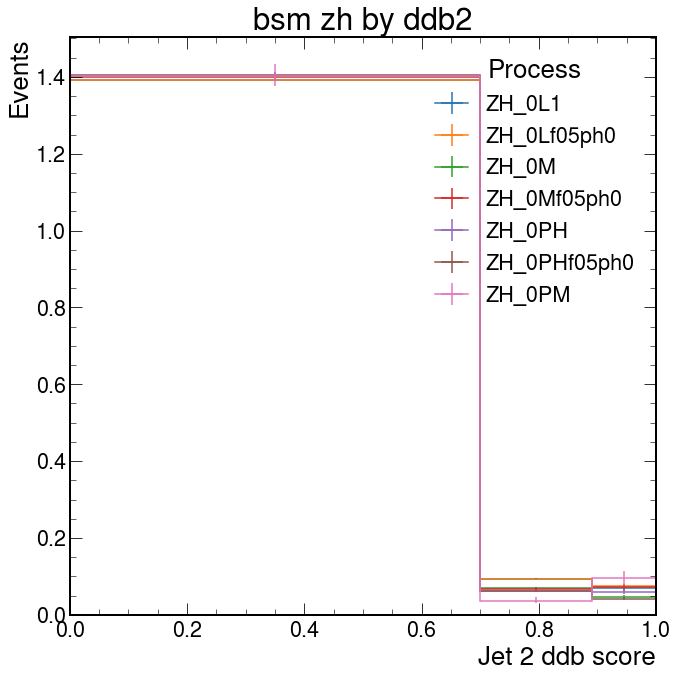

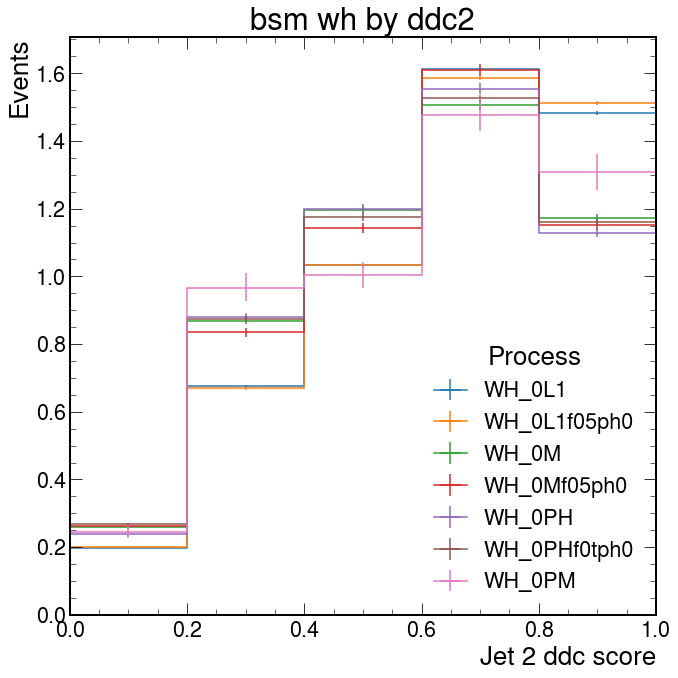

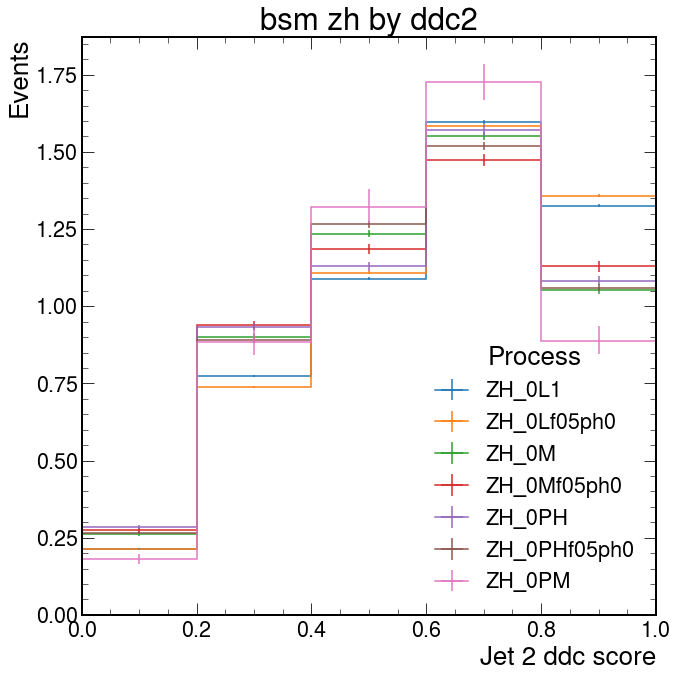

In [14]:
types = ['msd1', 'msd2', 'ddb1', 'ddb2', 'ddc2']
for x in types:
    plot_bsm(templatesw, x, '%s_wh.png'%x, 'wh', norm=True)
    plot_bsm(templatesz, x, '%s_zh.png'%x, 'zh', norm=True)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(


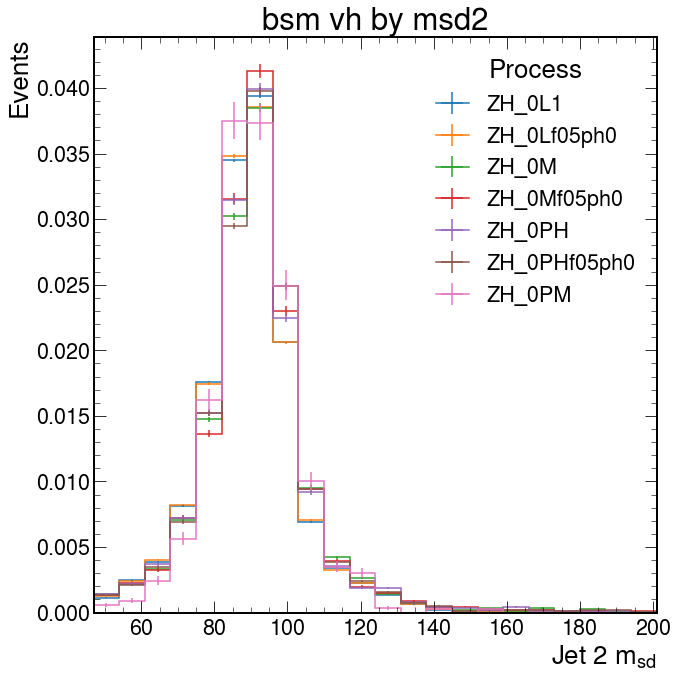

In [15]:
plot_bsm(templatesz, 'msd2', 'msd2_wh.png', 'vh', norm=True)

In [16]:
def sm_ratio(temp, v, save_title, mode, norm=False, save=True):
    '''
    keep ratio=false for now, true will throw an error. I'm working on it
    
    '''
    if mode == 'vbf':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
        res = temp.integrate('systematic', 'nominal')
    
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, mjj, deta, or pt1')
    if mode[-1]=='h':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'msd2':[68, 103], 'ddb2':[0, 1], 'ddc2':[0, 1]}
        res = temp
        if v not in vals.keys():
            
            raise KeyError('Please enter a valid variable: msd1, ddb1, msd2, ddb2, ddc2')
    
    
    for x in vals.keys():
        if not v==x:
            res = res.integrate(x, int_range=slice(*vals[x]))
    
    procs = [[y for y in res.integrate('process', str(x)).values().values()][0] for x in res.identifiers('process')]
    bins = [x.lo for x in res.identifiers(v)]
    labels = [str(x) for x in res.identifiers('process')]
    
    plt.figure()
    for x in range(len(procs)-1):
        
        plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
        plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
        
    plt.plot(bins, np.ones(len(bins)), label="SM prediction")
    lgd = plt.legend(bbox_to_anchor=(1.04, 1),loc='upper right', borderaxespad=0)
    plt.title("bsm %s by %s"%(mode, v))
    plt.xlabel(v)
    plt.ylabel('# Sample events/# OPM events')
    plt.tight_layout()
    if save:
        plt.savefig(save_title, bbox_inches='tight')
    #plt.close()

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d1f46dac0>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)


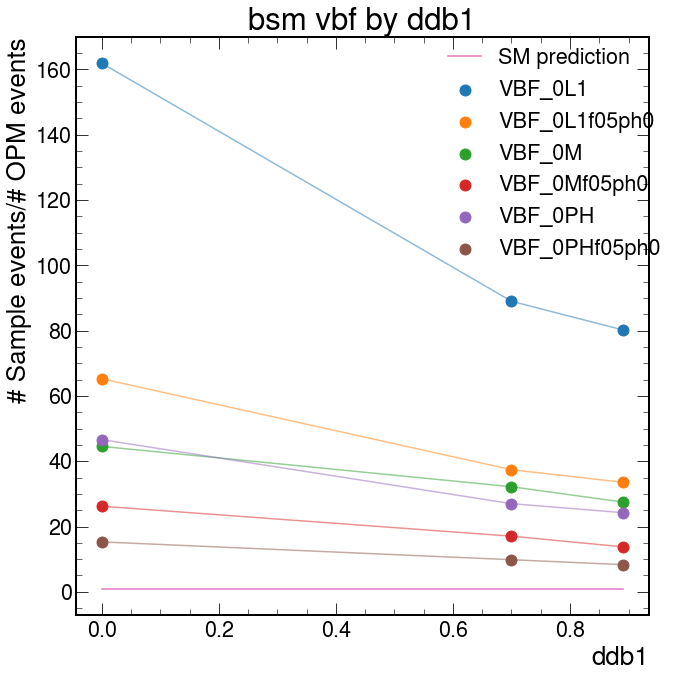

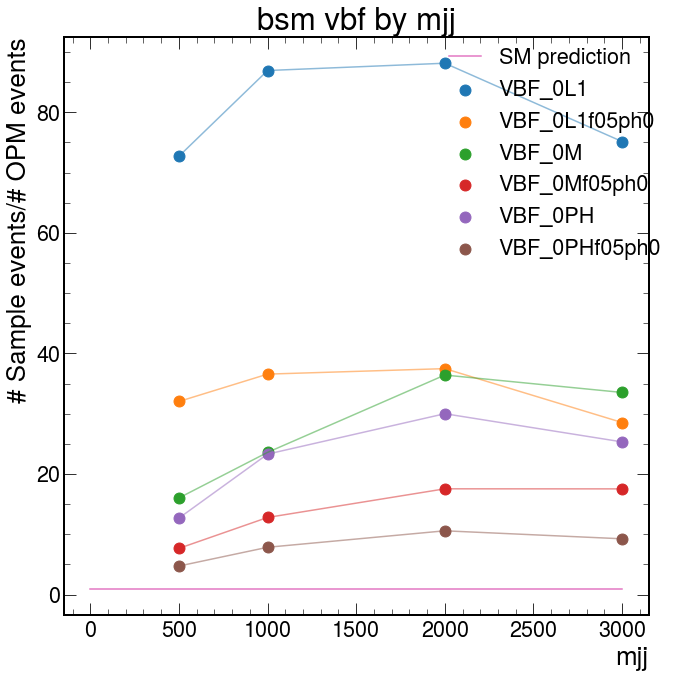

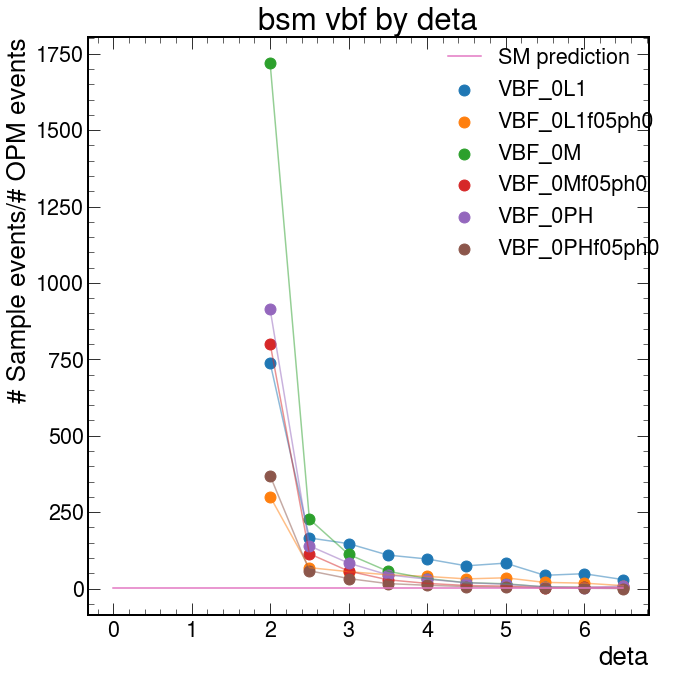

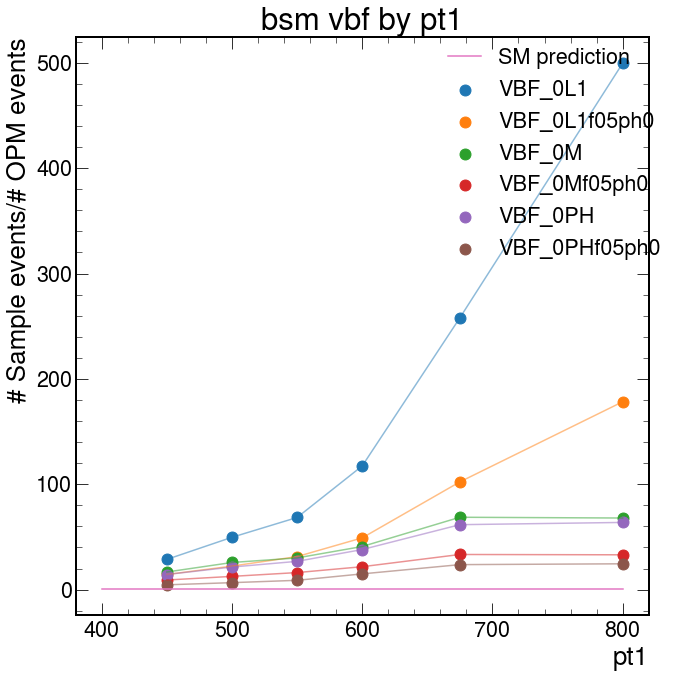

In [17]:
vbf_vars = ['ddb1', 'mjj', 'deta', 'pt1']
for x in vbf_vars:
    sm_ratio(templates, x, 'plots/vbf/0pm-norm-%s-vbf.png'%x, 'vbf')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)


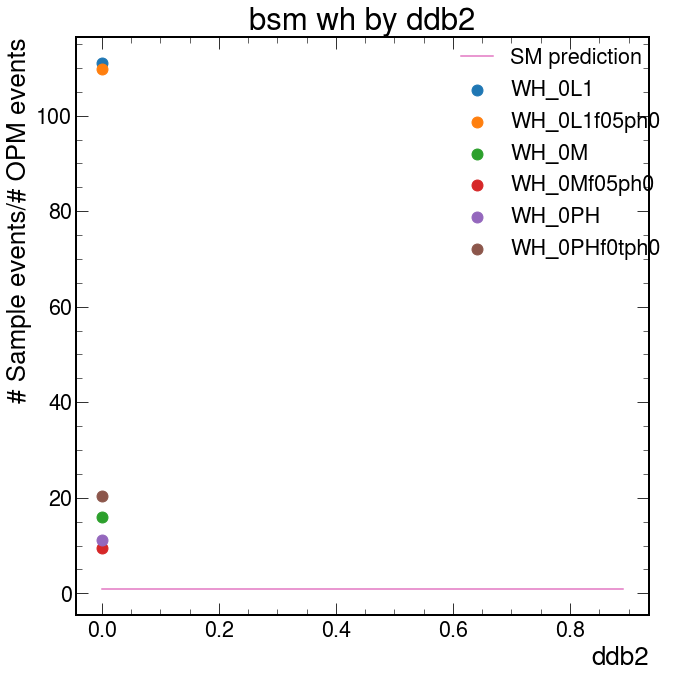

In [18]:
'''
I thought this plot was strange because the points are all zero after the first,
this is because OPM is zero after the first point so they are not zero, they
are nan bc of a divide by zero error
'''

x = 'ddb2'
sm_ratio(templatesw, x, 'plots/wh/0pm-norm-%s-wh.png'%x, 'wh')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/t

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)
/tmp/ipykernel_2434/3437804004.py:32: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(bins, procs[x]/procs[-1], s=120, label = labels[x])
/tmp/ipykernel_2434/3437804004.py:31: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins, procs[x]/procs[-1], alpha=0.5)


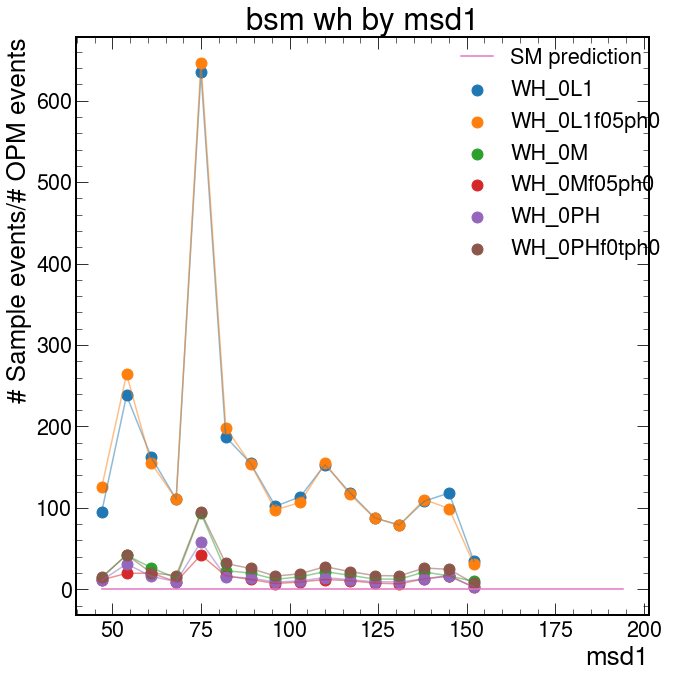

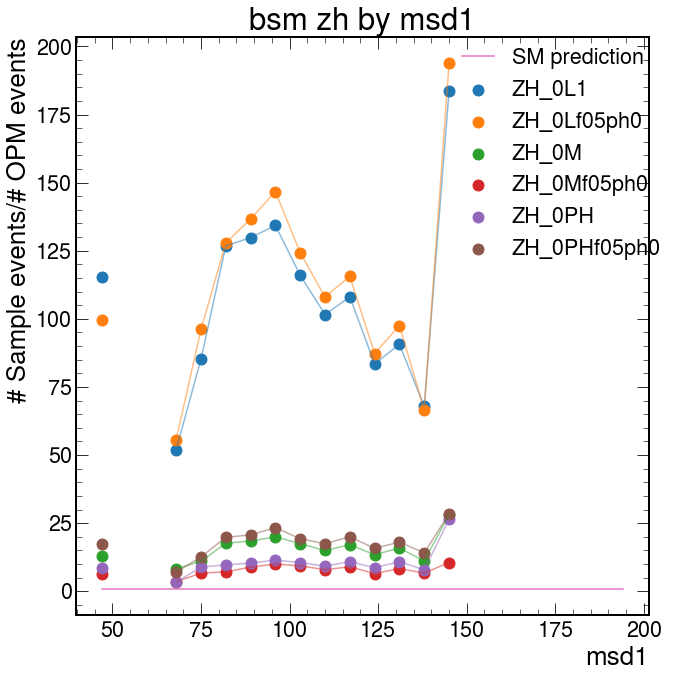

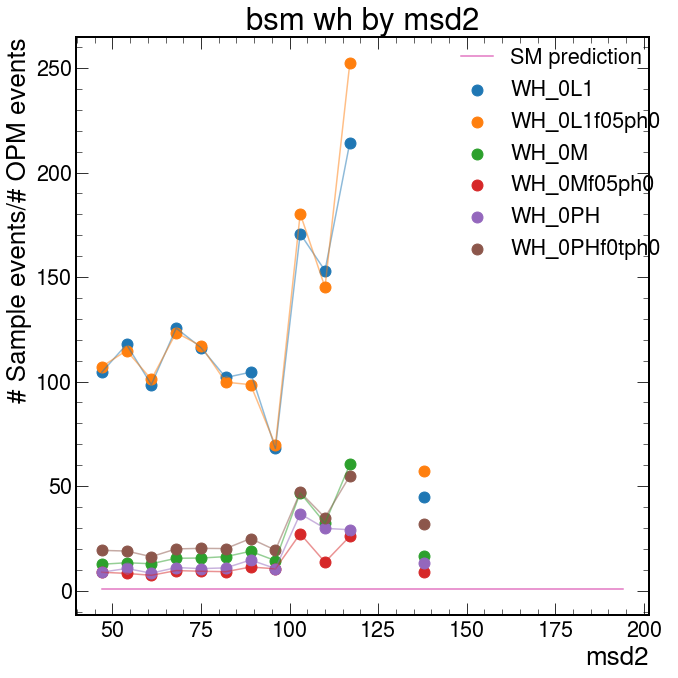

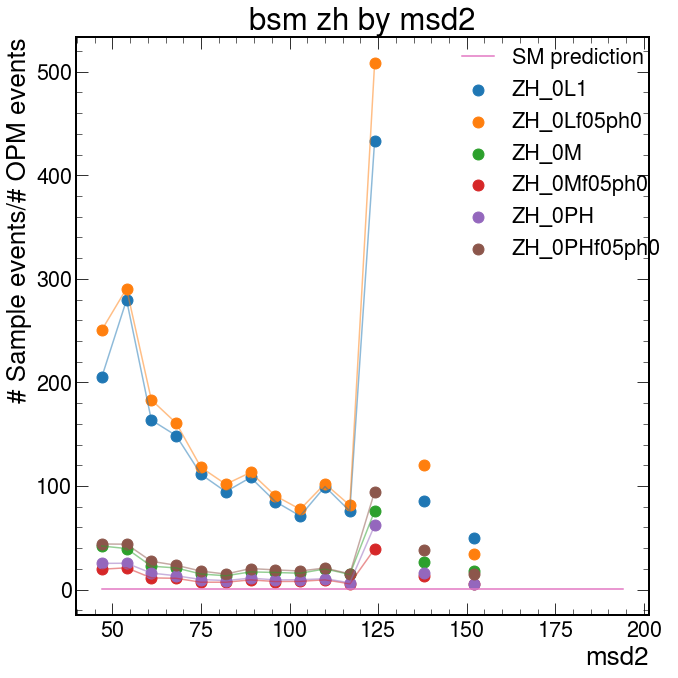

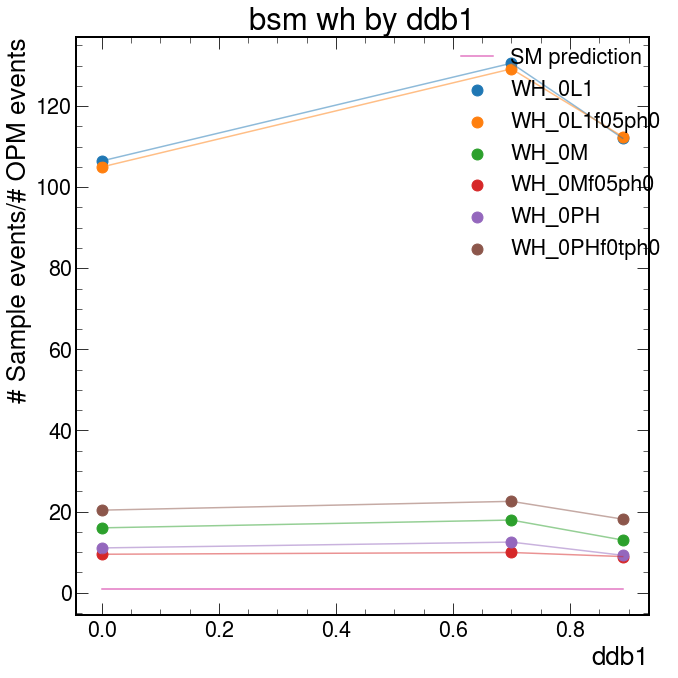

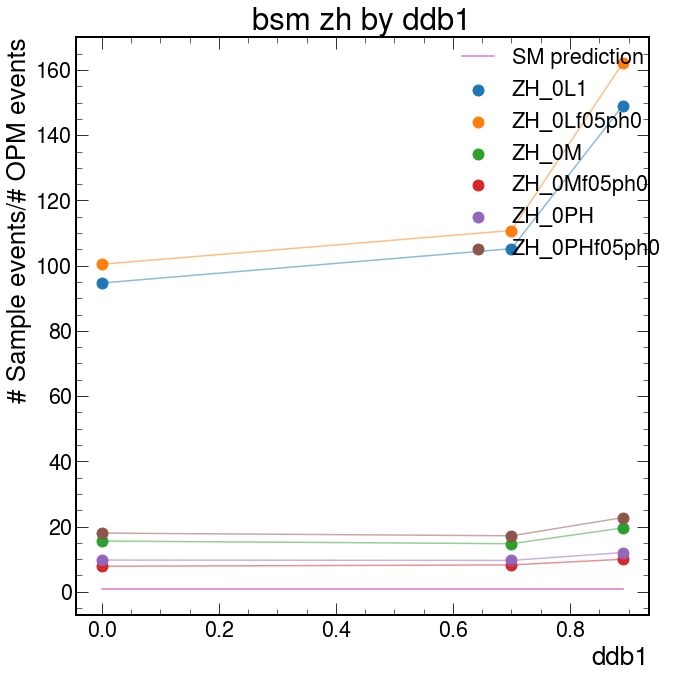

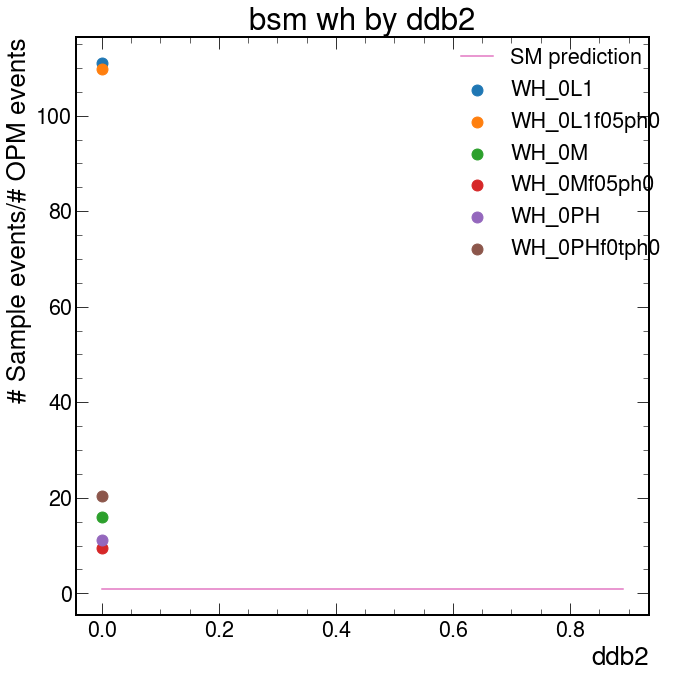

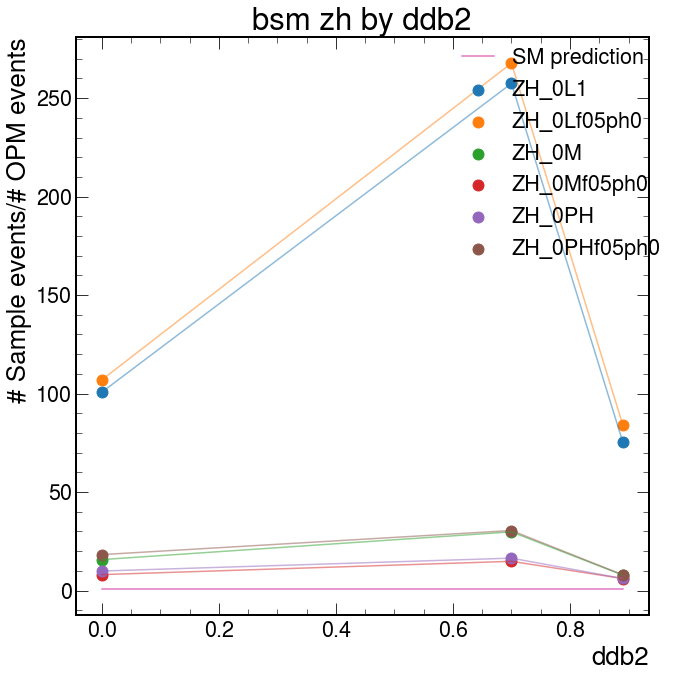

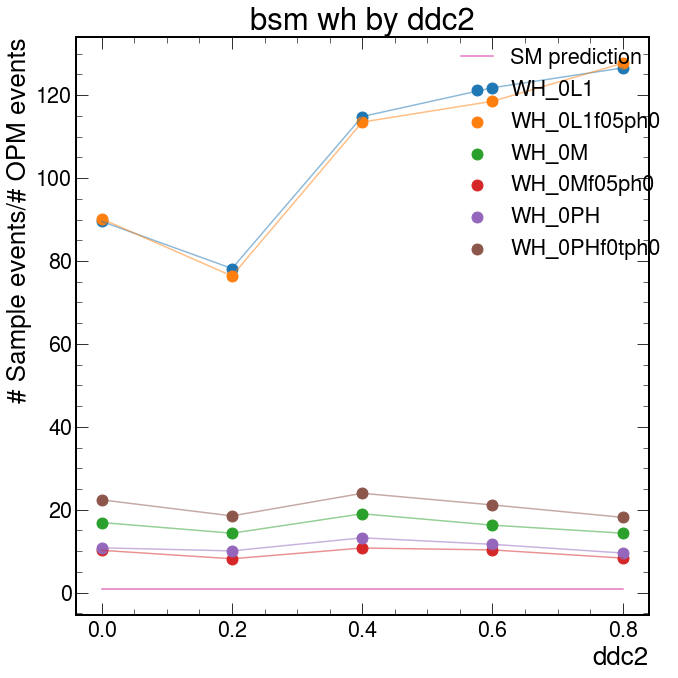

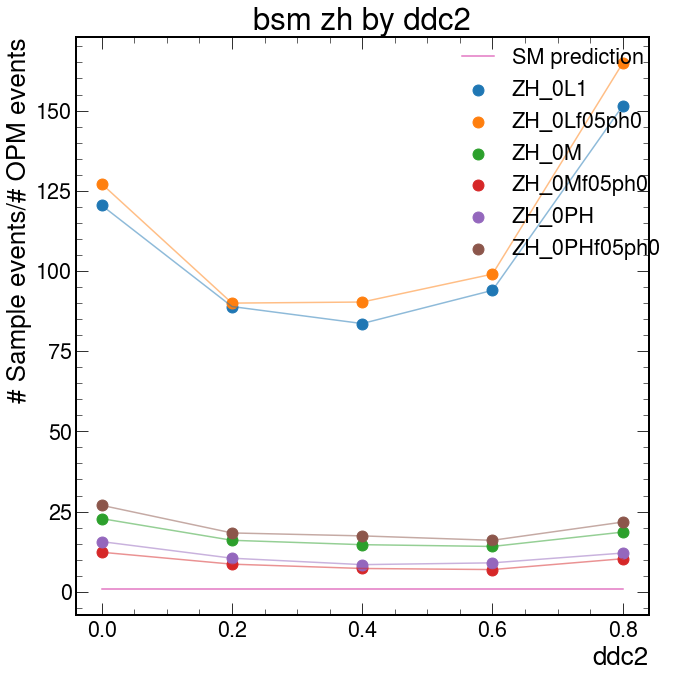

In [19]:
for x in types:
    sm_ratio(templatesw, x, 'plots/wh/0pm-norm-%s-wh.png'%x, 'wh')
    sm_ratio(templatesz, x, 'plots/zh/0pm-norm-%s-zh.png'%x, 'zh')
    #sm_ratio(templatesvh1, x, 'plots/vh/0pm-norm-%s-vh.png'%x, 'vh')

In [21]:
def zcp(s01, b, s901):
    '''
    Signifigance of divergence from standard model
    s01: standard model
    s901: signal yeild
    b: background
    '''
    if (s901+b) == 0 or 2*(s01 + b)*np.log((s01+b))/(s901+b) - 2*(s01+b)+2*(s901+b) < 0:
        return 0
    return np.sqrt(2*(s01 + b)*np.log((s01+b))/(s901+b) - 2*(s01+b)+2*(s901+b))
Zcp = np.vectorize(zcp)

In [22]:
def sm_sig(temp, mode, sm, b, norm=False, save=True):
    '''
    keep ratio=false for now, true will throw an error. I'm working on it
    
    '''
    if mode == 'vbf':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
        res = temp.integrate('systematic', 'nominal')
    
    if mode[-1]=='h':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'msd2':[68, 103], 'ddb2':[0, 1], 'ddc2':[0, 1]}
        res = temp
    
    
    for x in vals.keys():
        res = res.integrate(x, int_range=slice(*vals[x]))
    
    out_list = {}
    for x in res.values():
        out_list[x]= Zcp(sm, b, res.values()[x])
    return out_list

In [23]:
picklename = 'pickles/templates.pkl'
# Read the histogram from the pickle file
templates1 = pickle.load(open(picklename,'rb'))

# Sum over all bins and print the total number of events per process
templates1.sum('msd1','deta','mjj','ddb1').values()


picklename_2 = 'pickles/templates_2.pkl'
templates_2 = pickle.load(open(picklename_2,'rb'))

templates_2.sum('msd1','deta','mjj','ddb1').integrate('systematic', 'nominal').values()

{('ZH',): array(14.30482859),
 ('WH',): array(11.41398191),
 ('ttH',): array(21.68612532),
 ('VBF',): array(32.28007896),
 ('ggF',): array(75.87214395),
 ('ggF-powheg',): array(154.90639948),
 ('QCD',): array(3956029.49910738),
 ('VV',): array(1273.53049952),
 ('Wjets',): array(87111.29949286),
 ('Zjets',): array(37622.62585502),
 ('ttbar',): array(19498.99464288),
 ('singlet',): array(3073.46512155)}

In [24]:
v1 = templates1.sum('msd1','deta','mjj','ddb1').values()
v2 = templates_2.sum('msd1','deta','mjj','ddb1').integrate('systematic', 'nominal').values()


v1_sm = v1[('VBF',)]
v1_background = 0
for x in v1:
    if  not x[0]=='VBF':
        v1_background += v1[x]
        
        
v2_sm = v2[('VBF',)]
v2_background = 0
for x in v2:
    if  not x[0]=='VBF':
        v2_background += v2[x]

In [25]:
templates1.identifiers('process')

[<StringBin (QCD) instance at 0x7f9cfd6e4e80>,
 <StringBin (VBF) instance at 0x7f9cfd4fae50>,
 <StringBin (VV) instance at 0x7f9cfd283cd0>,
 <StringBin (WH) instance at 0x7f9cfd421130>,
 <StringBin (Wjets) instance at 0x7f9d05ccdca0>,
 <StringBin (ZH) instance at 0x7f9cfd599d00>,
 <StringBin (Zjets) instance at 0x7f9cfcdc5160>,
 <StringBin (ggF) instance at 0x7f9cfd1ba6d0>,
 <StringBin (ggF-powheg) instance at 0x7f9cfcb85bb0>,
 <StringBin (singlet) instance at 0x7f9cfd264820>,
 <StringBin (ttH) instance at 0x7f9cfce39b20>,
 <StringBin (ttbar) instance at 0x7f9cfcdc52b0>]

In [26]:
b_processes = [('ZH',), ('QCD'), ('VV',), ('WH',), ('Wjets',), ('ZH',),
              ('ZH',), ('Zjets',), ('ggF',), ('ggF-powheg',),('singlet',),
              ('ttH',), ('ttbar',)]

#templates1.sum('msd1', 'deta', 'mjj').integrate('process', b_processes).values()[()]

vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
k = list(vals.keys())
k.remove('msd1')
k

['ddb1', 'mjj', 'deta', 'pt1']

In [27]:
templates1.identifiers('process')

[<StringBin (QCD) instance at 0x7f9cfd6e4e80>,
 <StringBin (VBF) instance at 0x7f9cfd4fae50>,
 <StringBin (VV) instance at 0x7f9cfd283cd0>,
 <StringBin (WH) instance at 0x7f9cfd421130>,
 <StringBin (Wjets) instance at 0x7f9d05ccdca0>,
 <StringBin (ZH) instance at 0x7f9cfd599d00>,
 <StringBin (Zjets) instance at 0x7f9cfcdc5160>,
 <StringBin (ggF) instance at 0x7f9cfd1ba6d0>,
 <StringBin (ggF-powheg) instance at 0x7f9cfcb85bb0>,
 <StringBin (singlet) instance at 0x7f9cfd264820>,
 <StringBin (ttH) instance at 0x7f9cfce39b20>,
 <StringBin (ttbar) instance at 0x7f9cfcdc52b0>]

In [28]:
sm_sig(templates, 'vbf', v2_sm, v2_background, norm=False, save=True)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d1f46dac0>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(


{('VBF_0L1f05ph0',): array(34.31156151),
 ('VBF_0L1',): array(53.55738655),
 ('VBF_0Mf05ph0',): array(21.79101147),
 ('VBF_0M',): array(30.92426563),
 ('VBF_0PHf05ph0',): array(16.40252358),
 ('VBF_0PH',): array(28.98844411),
 ('VBF_0PM',): array(0)}

In [29]:
def sm_sig2(temp, v, save_title, mode, b_temp, norm=False, save=True, close=False, cut=False, cuts=None):
    '''
    keep ratio=false for now, true will throw an error. I'm working on it
    temp: templates for process
    v: variable plot should be binned by
    save_title: the title of the plot that will be saved
    mode: vbf/vh/zh/wh, must match templates
    b_temp: templates for background
    norm: normalize plot by area?
    save: if a plot will be saved
    close: if the plot should be closed after creation (set to True if you're making a lot of plots in a row)
    
    '''
    
    #get ranges for non-focus variables, raise an error if user has chosen a non-existent variable
    if mode == 'vbf':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
        res = temp.integrate('systematic', 'nominal')
        b_processes = [('QCD'), ('VV',), ('WH',), ('Wjets',),
                       ('Zjets',), ('ggF',), ('ggF-powheg',),('singlet',), ('ttH',), ('ttbar',)]
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, mjj, deta, or pt1')
    if mode[-1]=='h':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'msd2':[68, 103], 'ddb2':[0, 1], 'ddc2':[0, 1]}
        res = temp
        b_processes = [('ZH',), ('VBF',), ('QCD'), ('VV',), ('WH',), ('Wjets',), ('ZH',),
              ('ZH',), ('Zjets',), ('ggF',), ('ggF-powheg',),('singlet',),
              ('ttH',), ('ttbar',)]
        if v not in vals.keys():
            
            raise KeyError('Please enter a valid variable: msd1, ddb1, msd2, ddb2, ddc2')
    
    #integrate data on all non-focus variables
    for x in vals.keys():
        if not v==x:
            if cut and x in cuts:
                res = res.integrate(x, int_range=slice(*cuts[x]))
            else:
                res = res.integrate(x, int_range=slice(*vals[x]))
     
    #scale data by standard model prediction
    if norm:
        xtra = res.integrate(v, int_range=slice(*vals[v])).values()
        scale_factors = [xtra[('ZH_0PM',)]/xtra[x] for x in xtra.keys()]

        xtra = res.integrate(v, int_range=slice(*vals[v])).values()
        scale_factors = {}
        for x in xtra.keys():
            scale_factors[x[0]] = xtra[('ZH_0PM',)]/xtra[x] 
        res.scale(scale_factors, axis='process')
    
    #put data into lists so that significance can be computed
    procs = [[y for y in res.integrate('process', str(x)).values().values()][0] for x in res.identifiers('process')]
    bins = [x.lo for x in res.identifiers(v)]
    bmax = res.identifiers(v)[-1].hi
    labels = [str(x) for x in res.identifiers('process')]
    
    #get background data
    k = ['msd1','ddb1','deta','mjj']
    if v in k:
        k.remove(v)
    
    b = b_temp.sum(*k).integrate('process', b_processes).integrate('systematic', 'nominal').values()[()]
    if v=='ddb1':
        b = [sum(b[:70]),  sum(b[70:89]),  sum(b[89:])]
    
    
    #plot each of the processes
    plt.figure()
    qsigs = {}
    for x in range(len(procs)-1):
        sigs = Zcp(procs[-1], b, procs[x])
        plt.plot(bins, sigs, label = labels[x])
        qsigs[labels[x]] = (sum(np.multiply(sigs, sigs)))
    
    
    lgd = plt.legend()#bbox_to_anchor=(1.04, 1),loc='upper right', borderaxespad=0)
    t_string = "bsm %s by %s"%(mode, v) + (", optimized cut" if cut else "")
    
    plt.title(t_string)
    plt.xlabel(v)
    plt.ylabel('Significance')
    plt.tight_layout()
    if save:
        plt.savefig(save_title, bbox_inches='tight')
    if close:
        plt.close()
    
    return qsigs

In [ ]:
varby = 'ddc2'
sm_sig2(templatesz, varby, 'plots/zh/difbincut-%s.png'%varby, 'zh', templates_2, 
        norm=True, save=True, cut=True, cuts={'ddb1':[0, 0.67]})

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:665: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f9d0dd3ea30>: requested stop 0.67 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9cfd5972e0>
  warnings.warn(


{'ZH_0L1': 399.19510155729955,
 'ZH_0Lf05ph0': 434.75375382788474,
 'ZH_0M': 266.24382314272225,
 'ZH_0Mf05ph0': 347.04769815318286,
 'ZH_0PH': 279.29944561515003,
 'ZH_0PHf05ph0': 245.618280839175}

In [ ]:
templates_2.identifiers('ddb1')[70]


## Archive:
The home of poorly written code that will never be fixed

In [17]:
def sm_ratio2(temp, v, save_title, mode, norm=False, save=True):
    '''
    like sm_ratio, but much, much worse
    
    '''
    if mode == 'vbf':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'mjj':[1000, 4000], 'deta':[3.5, 7], 'pt1':[450, 1200]}
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, mjj, deta, or pt1')
    if mode == 'zh' or mode == 'wh':
        vals = {'msd1':[47, 201], 'ddb1':[0.64, 1], 'msd2':[68, 103], 'ddb2':[0, 1], 'ddc2':[0, 1]}
        if v not in vals.keys():
            raise KeyError('Please enter a valid variable: msd1, ddb1, msd2, ddb2, ddc2')
    
    res = temp.integrate('systematic', 'nominal')
    
    for x in vals.keys():
        if not v==x:
            res = res.integrate(x, int_range=slice(*vals[x]))
    
    labels = res.identifiers('process')
    procs = [res.integrate('process', x) for x in labels]
    
    
    fig, ax = plt.subplots(len(labels)-1, 1)
    fig.set_size_inches((20, 50))
    for x in range(len(procs)-1):
        hist.plotratio(procs[x], procs[-1], ax = ax[x], unc='poisson-ratio', label=labels[x], clear=True)
    
    
    plt.tight_layout()
    plt.savefig(save_title)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f22c1a02730>: requested start 0.64 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3455: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:452: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom ** 2)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.p

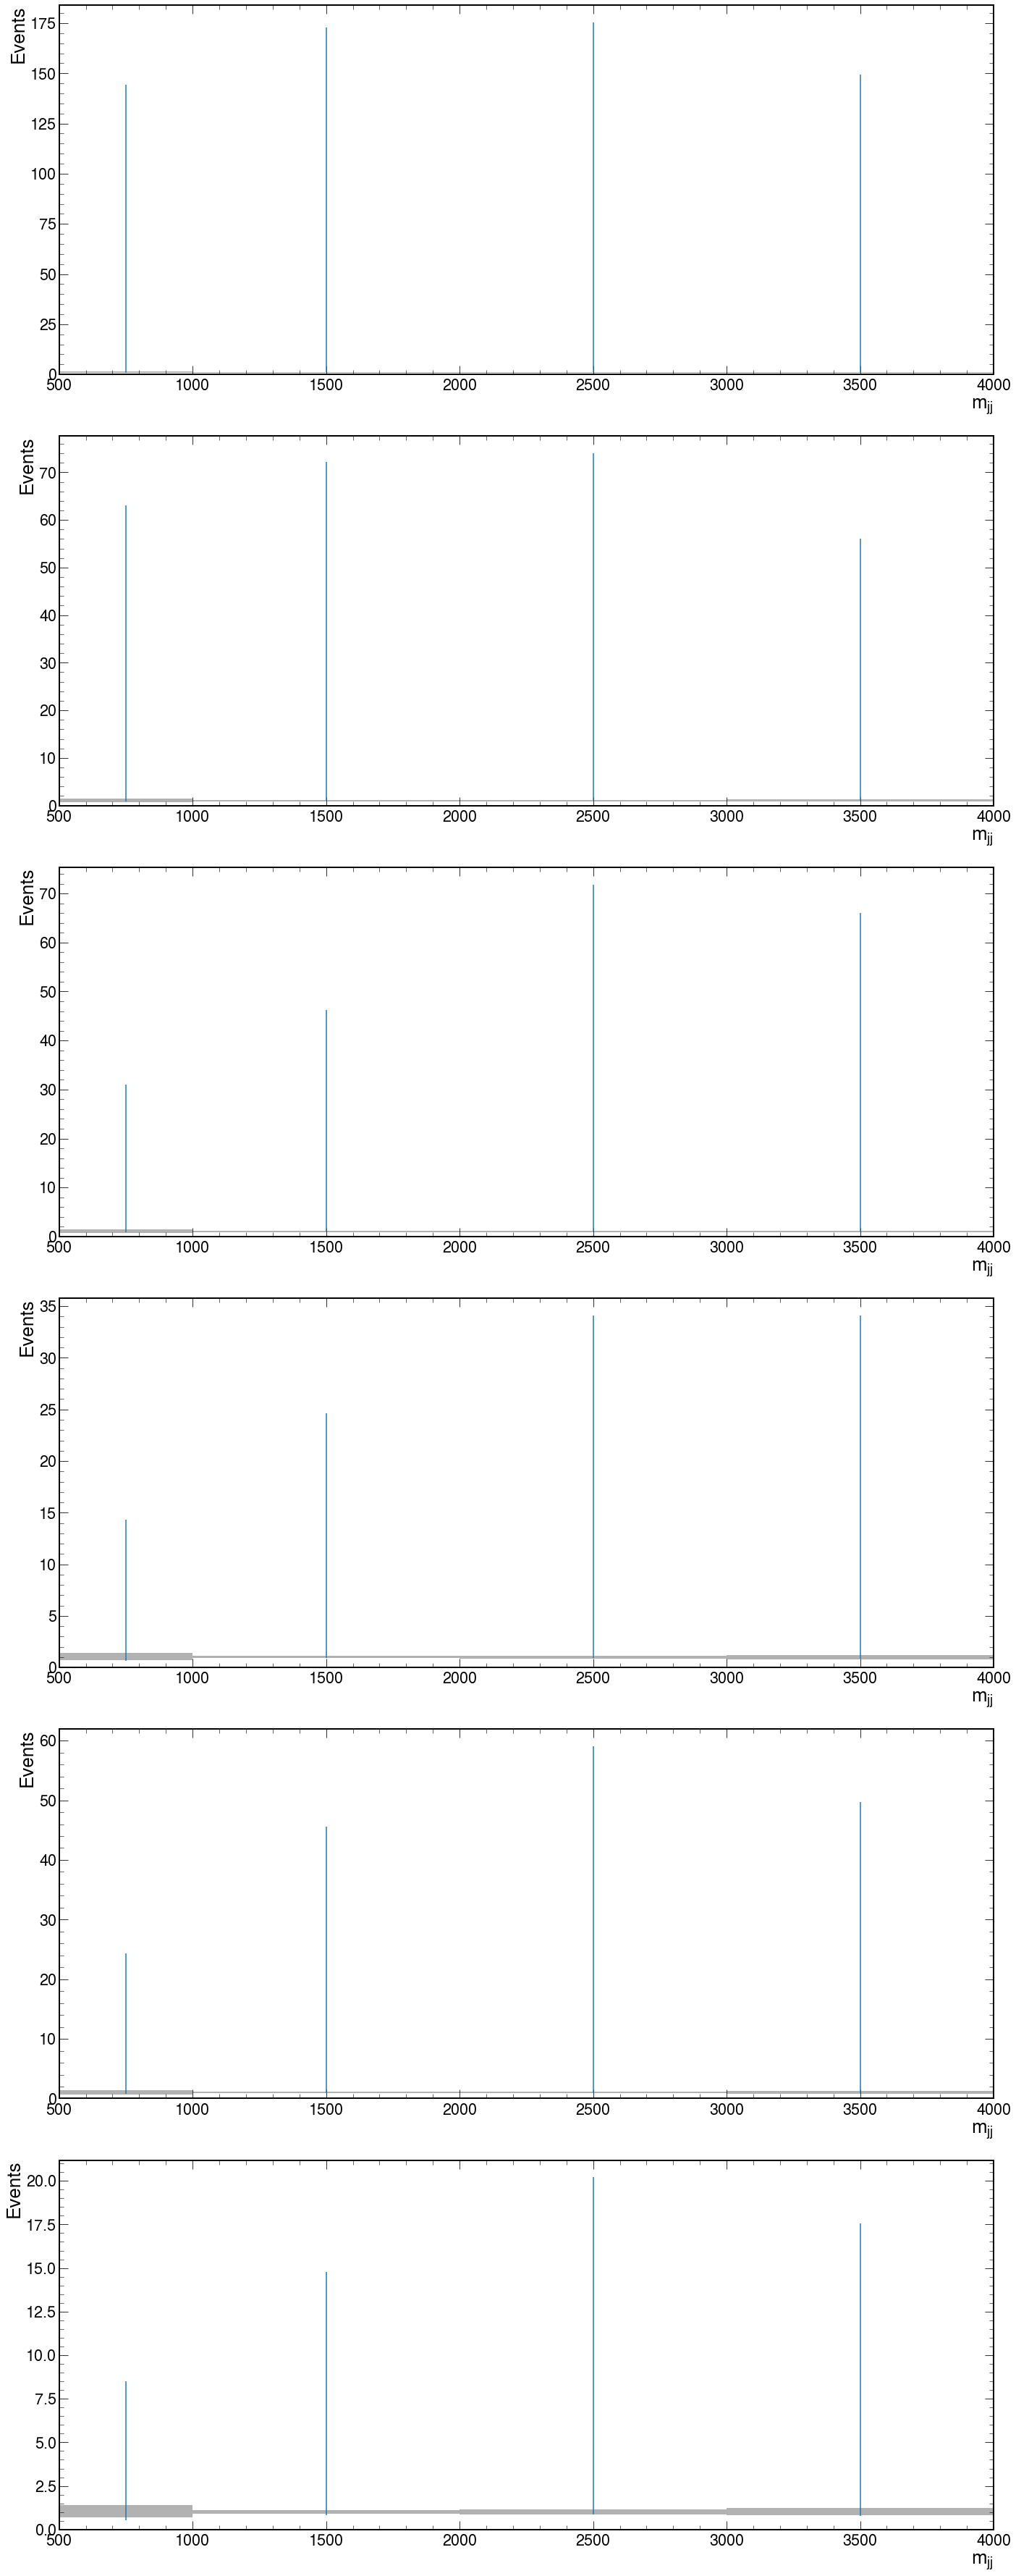

In [18]:
sm_ratio2(templates, 'mjj', 'thisbetterwork.png', 'vbf')